In [1]:
%matplotlib inline 

# Caching Rest Data Investigation
***

## Table of Contents
***

## Aim <a class="anchor" id="aim"></a>
***

The aim of this notebook is to do some Exploratory data analysis on the data obtained from the Caching Rest Application

## Code Setup <a class="anchor" id="code-setup"></a>
***

### Import Libraries

In [2]:
import pymysql
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

### Custom Classes

In [3]:
class CachePerformanceMetric:
    def __init__(self, cache_hit_size, cache_miss_size):
        self.cache_hit_size = cache_hit_size
        self.cache_miss_size = cache_miss_size
        self.total_size = cache_hit_size + cache_miss_size
        self.hit_ratio = cache_hit_size/self.total_size
    
    def __repr__(self):
        return "Hit Ratio : " + str(self.hit_ratio)

class MainCacheAnalyseData:
    def __init__(self, batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                cache_performance_per_batch, cache_remainder_per_batch):
        self.batch_ids = batch_ids
        self.cache_performance_metrics = cache_performance_metrics
        self.cache_initial_content_per_batch = cache_initial_content_per_batch
        self.cache_performance_per_batch = cache_performance_per_batch
        self.cache_remainder_per_batch = cache_remainder_per_batch

### Constants

In [4]:
db_connection = pymysql.connect("pidb","dbuser","password","cachetest" )

### Useful Functions

#### Table Read

In [5]:
def read_full_db_table(table_name):
    return pd.read_sql('SELECT * FROM ' + table_name, con=db_connection)

#### Query to Dataframe

In [6]:
def obtain_df_from_query(query_string):
    return pd.read_sql(query_string, con=db_connection)

#### Cache Hit Bytes to Boolean

In [7]:
def convert_cache_hit_to_boolean(df):
    df.cache_hit = df.cache_hit.map({b'\x00' : False, b'\x01' : True})
    return df

#### DF ids to comma seperated string

In [8]:
def df_ids_to_string(df):
    id_list = df.id.tolist()
    id_list = [str(i) for i in id_list]
    return ''.join(id_list)

#### Compute Average Hit Ratio

In [9]:
def compute_average_hit_ratio(cache_performance_metrics):
    average_hit_ratio = 0
    for cache_performance_metric in cache_performance_metrics:
        average_hit_ratio = average_hit_ratio + cache_performance_metric.hit_ratio
    average_hit_ratio = average_hit_ratio/(len(cache_performance_metrics))
    return average_hit_ratio

#### Compute Cache Size from Dataframe

In [10]:
def cache_size_mb_from_cache_content(df):
    return (df[["file_sizekb"]].sum().values[0])/1024

#### Process a Set of Parameters

In [11]:
def crunch_the_data(cache_type, cache_size_mb, eviction_policy):
    query_for_batch = ("cache_type == '" + cache_type + "' and cache_size_mb == '" + str(cache_size_mb) 
                       + "' and eviction_policy == '" + eviction_policy + "'")
    # Batches fitting criteria
    batches_df = batch_df.query(query_for_batch)
    
    if(batches_df.empty):
        print("Sorry, No batches for :", cache_type, ",", cache_size_mb, ",",  eviction_policy)
        return None
    
    # Cache Performance
    cache_performace_df = obtain_df_from_query("SELECT * FROM cache_performance cp where cp.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    # Issue with Booleans coming in as bytes and not booleans
    cache_performace_df = convert_cache_hit_to_boolean(cache_performace_df)
    
    # Cache Initial Content
    cache_initial_content_df = obtain_df_from_query("SELECT * FROM cache_initial_content cic where cic.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")
    # Cache Remainder
    cache_remainder_df = obtain_df_from_query("SELECT * FROM cache_remainder cr where cr.batch_id in ("
                                              + df_ids_to_string(batches_df)
                                              + ")")

    # Separate data into dictionary based on batches
    cache_performance_per_batch = {}
    cache_initial_content_per_batch = {}
    cache_remainder_per_batch = {}
    batch_ids = batches_df.id.unique().tolist()
    for batch_id in batch_ids :
        query_for_df = "batch_id == '" + str(batch_id) + "'"
        cache_performance_per_batch[batch_id] = cache_performace_df.query(query_for_df)
        cache_initial_content_per_batch[batch_id] = cache_initial_content_df.query(query_for_df)
        cache_remainder_per_batch[batch_id] = cache_remainder_df.query(query_for_df)
    
    # Compute the Cache Performance Metrics
    cache_performance_metrics = []
    for batch_id in batch_ids :
        cp_df = cache_performance_per_batch[batch_id]
        cic_df = cache_initial_content_per_batch[batch_id]
        cr_df = cache_remainder_per_batch[batch_id]
        
        print("For batch id :", batch_id)
        
        # Cache MB in Cache at Start
        initial_full_cache_size_mb = cache_size_mb_from_cache_content(cic_df)
        print("Cache Size at start of testing :", initial_full_cache_size_mb, " MB")
        
        # Calculate Hit Ratio
        cp_df_hit = cp_df.query("cache_hit")
        cp_df_miss = cp_df.query("cache_hit == False")
        hit_size = cp_df_hit.shape[0]
        miss_size = cp_df_miss.shape[0]
        cache_performance_metric = CachePerformanceMetric(hit_size, miss_size)
        cache_performance_metrics.append(cache_performance_metric)
        print("Cache Hits ", cache_performance_metric.cache_hit_size, ", Misses :", 
              cache_performance_metric.cache_miss_size, " Hit Ratio :", cache_performance_metric.hit_ratio)
        
        # Cache MB in Cache at End
        end_full_cache_size_mb = cache_size_mb_from_cache_content(cr_df)
        print("Cache Size at end of testing :", end_full_cache_size_mb, " MB")
        
        # Print line at the end
        print("------------------------------------------------------------------------------------------------------")
    
     
    # Average Hit Ratio
    average_hit_ratio = compute_average_hit_ratio(cache_performance_metrics)
    print("Average Hit Ratio :", average_hit_ratio)
    
    # Generate the important data made from this incase it is needed elsewhere
    main_analyse_data = MainCacheAnalyseData(batch_ids, cache_performance_metrics, cache_initial_content_per_batch,
                                            cache_performance_per_batch, cache_remainder_per_batch)
    
    return main_analyse_data

### Global Data

In [12]:
batch_df = read_full_db_table("batch")

## Data Import <a class="anchor" id="data-import"></a>
***

In [13]:
list_of_cache_types = batch_df.cache_type.unique().tolist()
for cache_type in list_of_cache_types :
    print(cache_type)

ehcache
hazelcast
memcached


## Ehcache Data

### Ehcache LRU 128 MB

In [14]:
ehcache_lru_128_data = crunch_the_data("ehcache", 128, "LRU")

For batch id : 3
Cache Size at start of testing : 127.2470703125  MB
Cache Hits  268 , Misses : 3961  Hit Ratio : 0.06337195554504611
Cache Size at end of testing : 127.076171875  MB
------------------------------------------------------------------------------------------------------
Average Hit Ratio : 0.06337195554504611


### Ehcache LRU 256 MB

In [15]:
#ehcache_lru_256_data = crunch_the_data("ehcache", 256, "LRU")

### Ehcache LRU 512 MB

In [16]:
#ehcache_lru_512_data = crunch_the_data("ehcache", 512, "LRU")

### Ehcache LRU 1024 MB

In [17]:
#ehcache_lru_1024_data = crunch_the_data("ehcache", 1024, "LRU")

## Hazelcast Data

### Hazelcast LRU 128 MB

In [18]:
hazelcast_lru_128_data = crunch_the_data("hazelcast", 128, "LRU")

For batch id : 8
Cache Size at start of testing : 127.71875  MB
Cache Hits  239 , Misses : 3940  Hit Ratio : 0.05719071548217277
Cache Size at end of testing : 132.353515625  MB
------------------------------------------------------------------------------------------------------
Average Hit Ratio : 0.05719071548217277


## Redis Data

### Redis LRU 128 MB

In [19]:
redis_lru_128_data = crunch_the_data("redis", 128, "LRU")

Sorry, No batches for : redis , 128 , LRU


## Memcached Data

### Memcached LRU 128 MB

In [20]:
memcached_lru_128_data = crunch_the_data("memcached", 128, "LRU")

Sorry, No batches for : memcached , 128 , LRU


## 128 MB LRU Comparison

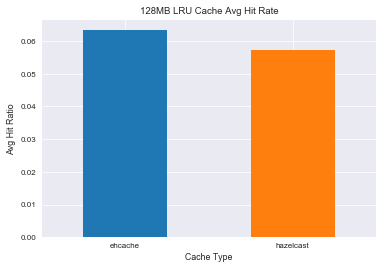

In [21]:
ehcache_lru_128_avg_hit_ratio = compute_average_hit_ratio(ehcache_lru_128_data.cache_performance_metrics)
hazelcast_lru_128_avg_hit_ratio = compute_average_hit_ratio(hazelcast_lru_128_data.cache_performance_metrics)

d = {"cache": ["ehcache", "hazelcast"], 
     "avg_hit_ratio" : [ehcache_lru_128_avg_hit_ratio, hazelcast_lru_128_avg_hit_ratio]}
df = pd.DataFrame(data=d)
fig, ax = plt.subplots()

df['avg_hit_ratio'].plot.bar()

ax.set_xticklabels(df["cache"], rotation='horizontal')
plt.xlabel('Cache Type')
plt.ylabel('Avg Hit Ratio')
plt.title('128MB LRU Cache Avg Hit Rate')
plt.show()